In [1]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt
from pylab import rcParams

In [2]:
rcParams['figure.figsize'] = 14, 28

In [3]:
from ImageHandler import *
from ImageProcessing import *
from Processing import *

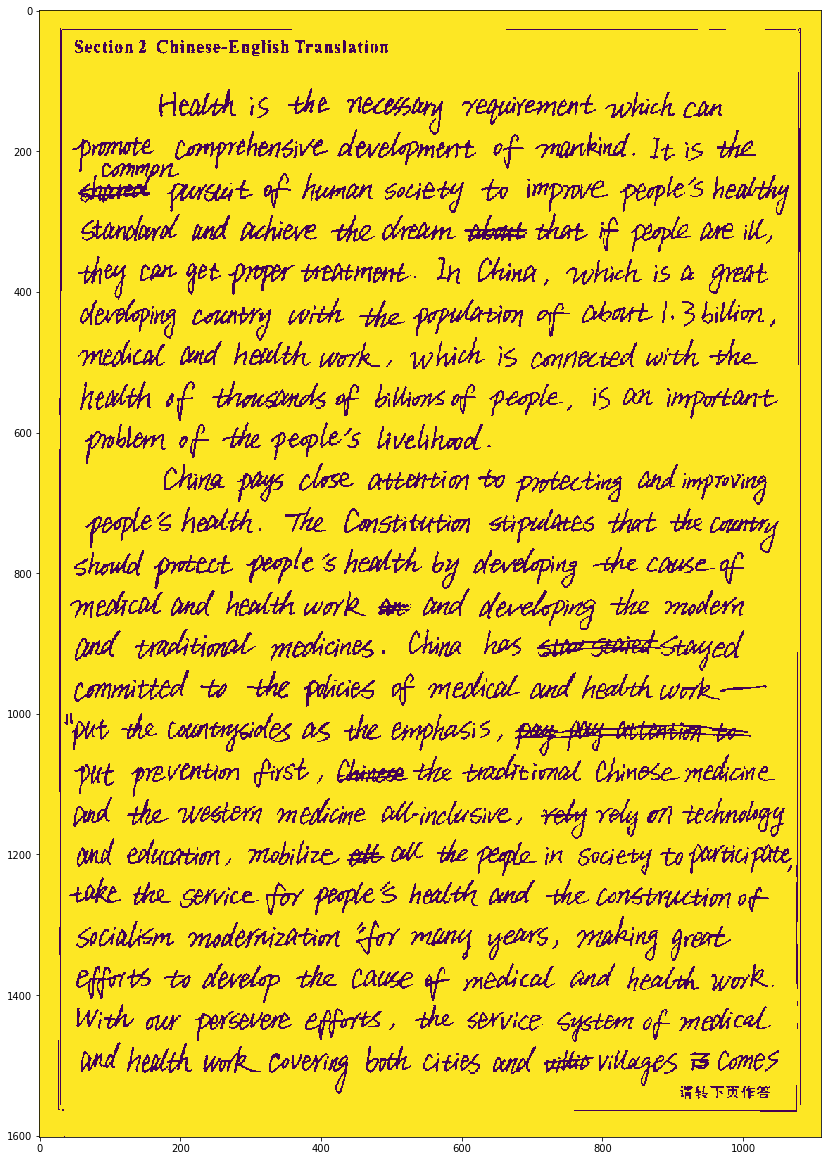

In [9]:
image = loadImage('Test-data/050200074.jpg');
# image = loadImage('../Dataset/600000107.jpg');
(h, w) = np.shape(image);
_, image = cv.threshold(image,0,255,cv.THRESH_BINARY+cv.THRESH_OTSU)
plt.imshow(image);

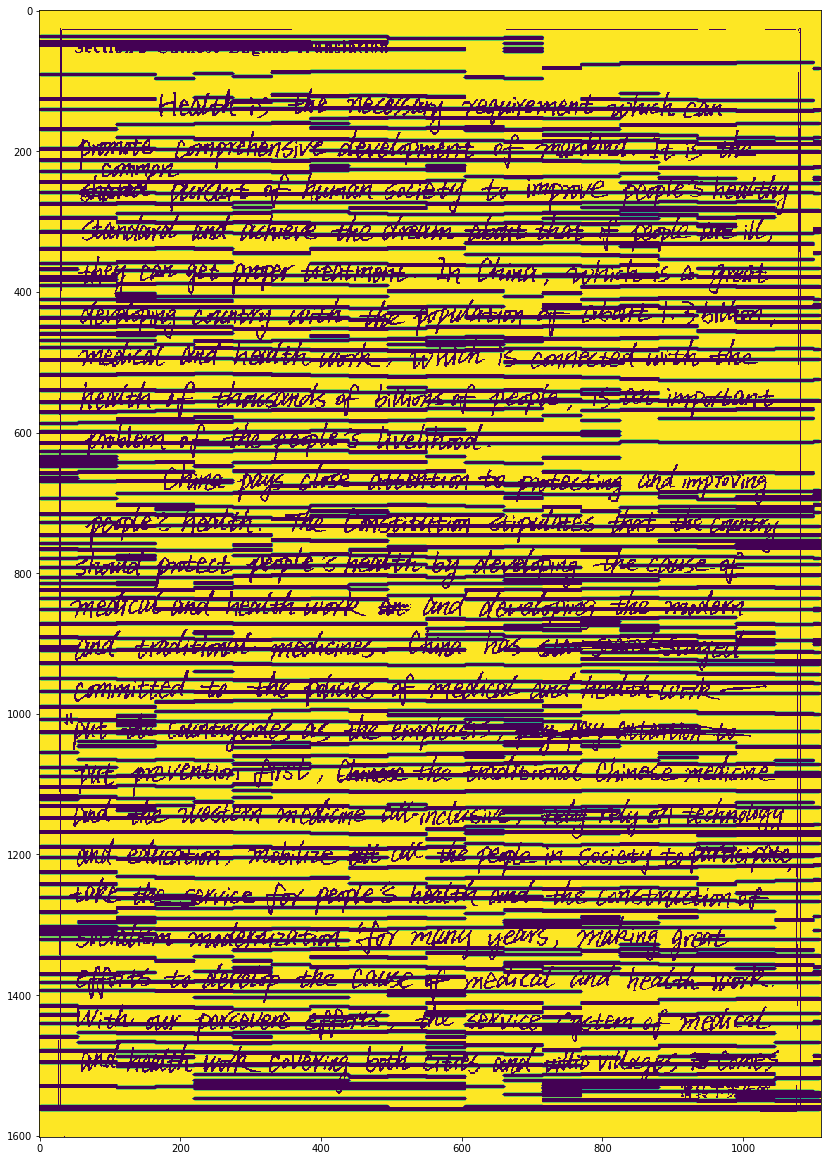

In [10]:
width = int (0.05 * w);
(h, w) = np.shape(image);
strips = (int (w/width) + (1 if w%width != 0 else 0));
M = 3;

wt = getWeights(M);
pp = [];
for i in range(strips):
    pp.append(projectionProfile(image, width, i));

delta = getdelta(image, width, strips, pp);
SPR = [];
for i in range(strips):
    SPR.append(getSPR(image, M, i, delta, wt, pp, strips));
    
dSPR = [];
CCheight = int (getCCHeight(image) / 2);
for i in range(strips):
    dSPR.append(getdiffSPR(SPR[i], image, CCheight));
showLine(image, dSPR, strips, width);

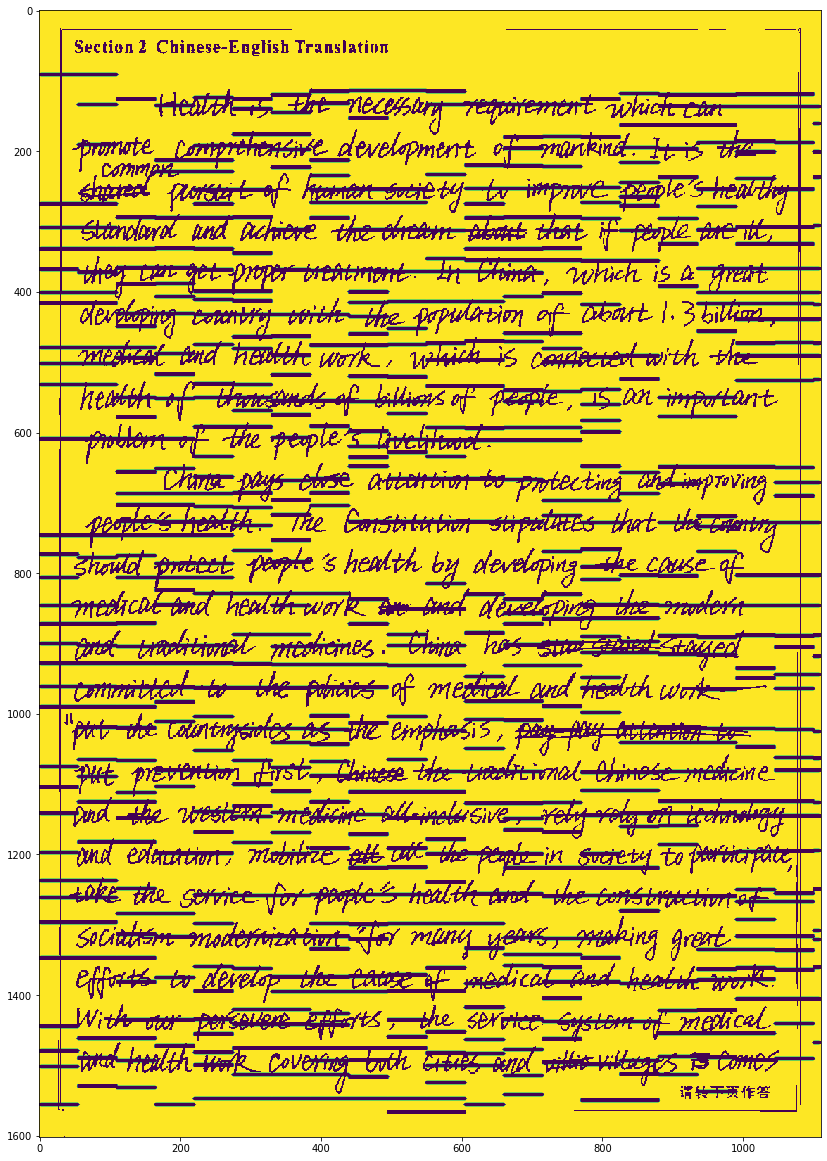

In [11]:
nRegions = applyViterbi(dSPR, strips, pp, width, CCheight, w)

pRegions = [];
for regionsStrip in nRegions:
    pRegionsStrip = [];
    tempRegion = [];
    gap = False
    for region in regionsStrip:
        if region[2] == 0:
            if gap:
                tempRegion[1] += region[1]
            else:
                if tempRegion != []:
                    pRegionsStrip.append(region[0] + int (region[1] / 2));
                tempRegion = region;
                gap = True;
        else:
            gap = False;
    pRegions.append (pRegionsStrip);
showProcessedRegions(image, pRegions, width, w);

805 806
275 276
178 179
1479 1480
804 805
804 -1
685 686
685 686
685 686
685 686
-1 -1
178 -1
276 277
865 866
864 865
873 874
1159 1160
1479 -1
865 -1
864 -1
873 -1
982 983
1159 1160
1159 1160
1159 1160
1159 1160
1159 1160
1158 1159
1158 1159
330 331
511 512
511 512
511 512
1334 1335
1451 1452
1395 1396
1353 1354
1353 1354
1353 1354
-1 -1


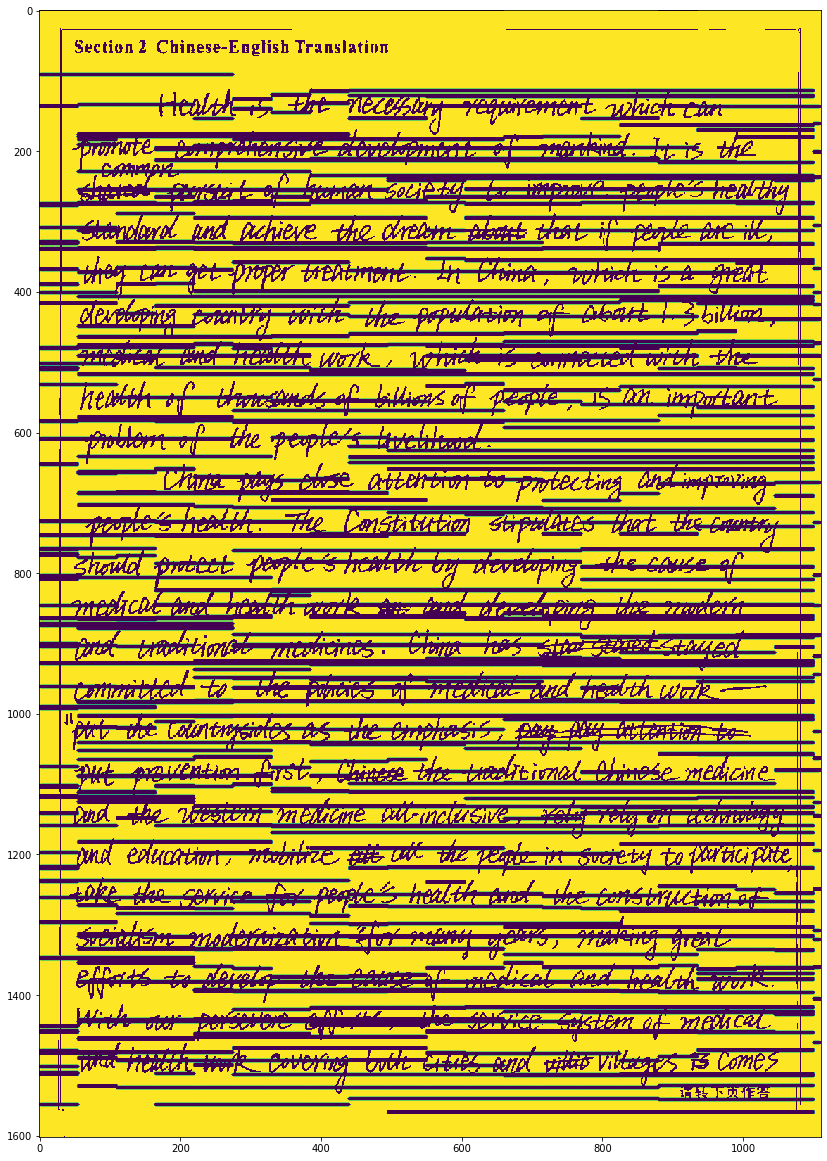

In [12]:
nRegions = applyViterbi(dSPR, strips, pp, width, CCheight, w)

pRegions = [];
for regionsStrip in nRegions:
    pRegionsStrip = [];
    tempRegion = [];
    gap = False
    for region in regionsStrip:
        if region[2] == 0:
            if gap:
                tempRegion[1] += region[1]
            else:
                if tempRegion != []:
                    pRegionsStrip.append(region[0] + int (region[1] / 2));
                tempRegion = region;
                gap = True;
        else:
            gap = False;
    pRegions.append (pRegionsStrip);
textRegions = connectSeparators(pRegions, delta, SPR, h);
showProcessedRegions(image, pRegions, width, w);

In [13]:
for i in range(strips):
    print (len(pRegions[i]), end = ' ');

93 94 94 95 95 95 95 95 95 96 96 96 96 96 96 96 96 96 96 96 31 

* CC is assigned if line cuts with >75% of CC above
* If CC is intersected with 2 lines, extend zone on both direction
* Find where line j are assigned unquestionabbly find Na
* Extend CC into that zone and find Nb and calc ratio
* r<0.4 assign to one with greater overlap, one above r then assign it, both above r then split CC
* Find junction point using paper given

In [10]:
labels = [];
stats = [];
centroids = [];
for i in range(strips):
    imageStrip = image[:,i*width : (i+1)*width if (i+1)*width < w else w];
    if delta[i] == 1:
        labelStrip, statStrip, centroidStrip = getCC(imageStrip);
    else:
        labelStrip, statStrip, centroidStrip = [], [], [];
    print (len(statStrip), end = ' ')
    labels.append(labelStrip);
    stats.append(statStrip);
    centroids.append(centroidStrip);

0 249 270 256 283 265 235 277 257 240 265 241 231 281 284 299 267 324 232 0 0 

In [20]:
# Extend lines to left side
chosenLines = [];
for i in range(strips):
    chosenLinesStrip = [];
    for stat in range(len(stats[i])):
        lines = getLineinRange(pRegions, stat[1], stat[1] + stat[3]);
        th75 = stat[1] + (0.75 * stat[3]);
        lines = [line for line in lines if line > th75];
        if len(lines) > 1:
            lines = extendZone(pRegions, stats, stat[1], stat[1] + stat[3], lines);
        chosenLinesStrip.extend(lines);
    chosenLines.append(chosenLinesStrip);

(1602, 1111)

In [11]:
def getLineinRange(Regions, top, bottom):
    
def extendZone(pRegions, stats, top, bottom, lines):

SyntaxError: invalid syntax (<ipython-input-11-bea610a146b2>, line 1)

In [39]:
delta

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0]